<a href="https://colab.research.google.com/github/rishikanigam/-Learning-to-Solve-Computational-Fluid-Dynamics-CFD-Equations-using-Fourier-Neural-Operator/blob/main/CFD_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1) check python + scipy versions first
import sys
print("Python:", sys.version)
try:
    import scipy
    print("scipy already:", scipy.__version__)
except Exception as e:
    print("scipy not importable:", e)

# 2) install a compatible scipy (no strict pin) and tqdm
# If SciPy is already present and OK you can skip this install line.
!pip install -q scipy tqdm


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
scipy already: 1.16.3


In [4]:
import importlib, scipy
importlib.reload(scipy)
print("scipy:", scipy.__version__)


scipy: 1.16.3


In [5]:
import sys, os, time
print("Python:", sys.version)
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import scipy
print("scipy:", scipy.__version__)
print("torch:", torch.__version__, "cuda:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
scipy: 1.16.3
torch: 2.8.0+cu126 cuda: False
Device: cpu


In [7]:
#@title Cell B — Dataset generation (DST Poisson solver, complete)
import numpy as np, os
from tqdm import trange
import scipy.fftpack as fftpack
from scipy.ndimage import gaussian_filter

def solve_poisson_dirichlet_dst(f):
    """
    Solve -Δu = f on (0,1)^2 with u=0 on boundary using DST.
    f: full grid (H,W)
    Returns u of same shape with zero Dirichlet boundary.
    """
    fx = f[1:-1, 1:-1]
    nx, ny = fx.shape
    # forward DST (type II)
    b = fftpack.dst(fftpack.dst(fx, type=2, axis=0), type=2, axis=1)
    # eigenvalues of discrete Laplacian
    ix = np.arange(1, nx+1)[:, None]
    iy = np.arange(1, ny+1)[None, :]
    h = 1.0/(nx+1)
    lam = (2*(1 - np.cos(np.pi*ix/(nx+1))) + 2*(1 - np.cos(np.pi*iy/(ny+1)))) / (h*h)
    u_hat = b / lam
    # inverse DST (type III)
    u_inner = fftpack.idst(fftpack.idst(u_hat, type=3, axis=0), type=3, axis=1)
    # scale correction for fftpack conventions
    u_inner *= (2/(nx+1)) * (2/(ny+1))
    u = np.zeros_like(f)
    u[1:-1, 1:-1] = u_inner
    return u

def make_random_rhs(H, W, smooth=2.0, seed=None):
    rng = np.random.RandomState(seed)
    f = rng.randn(H, W).astype(np.float32)
    f = gaussian_filter(f, sigma=smooth)
    f /= (np.max(np.abs(f)) + 1e-9)
    return f

def generate_dataset_poisson(out_path='dataset_poisson.npz', N=300, H=64, W=64, overwrite=False):
    if os.path.exists(out_path) and not overwrite:
        print(f"{out_path} already exists — skipping.")
        return out_path
    F = np.zeros((N, H, W), dtype=np.float32)
    U = np.zeros((N, H, W), dtype=np.float32)
    for k in trange(N, desc="Generating dataset"):
        f = make_random_rhs(H, W, smooth=2.0)
        u = solve_poisson_dirichlet_dst(f)
        F[k] = f
        U[k] = u
    np.savez_compressed(out_path, F=F, U=U)
    print(f"✅ Saved dataset to {out_path} | N={N}, grid={H}×{W}")
    return out_path

# --- now actually generate the data ---
if not os.path.exists('dataset_poisson.npz'):
    generate_dataset_poisson(out_path='dataset_poisson.npz', N=300, H=64, W=64)
else:
    print("dataset_poisson.npz exists — skipping generation.")


Generating dataset: 100%|██████████| 300/300 [00:00<00:00, 494.23it/s]


✅ Saved dataset to dataset_poisson.npz | N=300, grid=64×64


Dataset loaded:
  F shape: (300, 64, 64)
  U shape: (300, 64, 64)
  Value range: F ∈ [-1.000, 1.000], U ∈ [-0.164, 0.162]


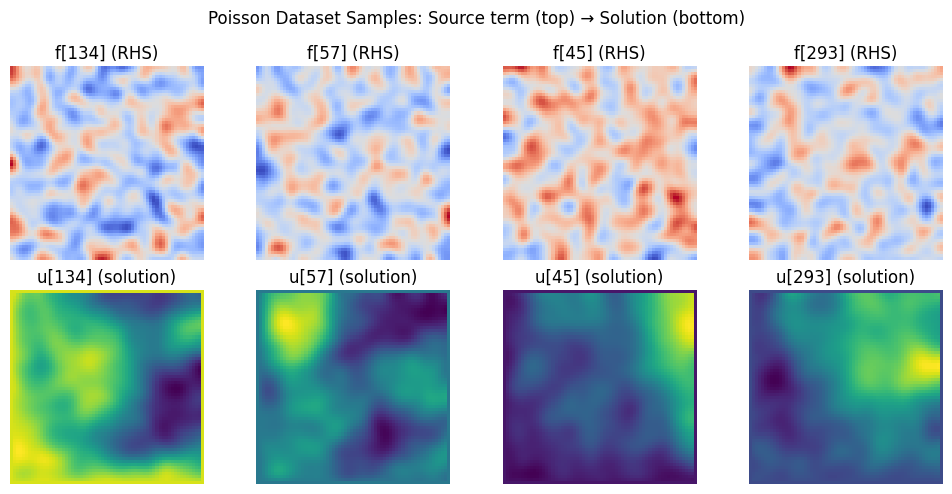

In [8]:
#@title Cell B2 — Visualize dataset samples
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
data = np.load('dataset_poisson.npz')
F = data['F']   # RHS fields
U = data['U']   # Solutions

print("Dataset loaded:")
print("  F shape:", F.shape)
print("  U shape:", U.shape)
print("  Value range: F ∈ [%.3f, %.3f], U ∈ [%.3f, %.3f]" %
      (F.min(), F.max(), U.min(), U.max()))

# Choose random samples to visualize
num_samples = 4
idxs = np.random.choice(F.shape[0], num_samples, replace=False)

plt.figure(figsize=(10, 5))
for i, idx in enumerate(idxs):
    plt.subplot(2, num_samples, i+1)
    plt.imshow(F[idx], origin='lower', cmap='coolwarm')
    plt.title(f"f[{idx}] (RHS)")
    plt.axis('off')

    plt.subplot(2, num_samples, num_samples + i+1)
    plt.imshow(U[idx], origin='lower', cmap='viridis')
    plt.title(f"u[{idx}] (solution)")
    plt.axis('off')

plt.suptitle("Poisson Dataset Samples: Source term (top) → Solution (bottom)")
plt.tight_layout()
plt.show()


In [9]:
#@title Cell C — Define Fourier Neural Operator (FNO2D)
import torch
import torch.nn as nn
import torch.fft as fft

# --- Fourier convolution layer ---
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2
        # complex weights stored as two real parts
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, modes1, modes2, 2))

    def forward(self, x):
        # x: (batch, in_ch, H, W)
        x_ft = fft.rfft2(x, dim=(-2, -1))
        batch, in_ch, H_ft, W_ft = x_ft.shape
        m1 = min(self.modes1, H_ft)
        m2 = min(self.modes2, W_ft)
        out_ft = torch.zeros(batch, self.out_channels, H_ft, W_ft, dtype=torch.cfloat, device=x.device)
        W = torch.view_as_complex(self.weights)
        out_ft[:, :, :m1, :m2] = torch.einsum('b i m n, i o m n -> b o m n', x_ft[:, :, :m1, :m2], W.to(x.device))
        x = fft.irfft2(out_ft, s=(x.shape[-2], x.shape[-1]))
        return x

# --- Full FNO model ---
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super().__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width

        self.fc0 = nn.Linear(1, width)

        self.conv0 = SpectralConv2d(width, width, modes1, modes2)
        self.conv1 = SpectralConv2d(width, width, modes1, modes2)
        self.conv2 = SpectralConv2d(width, width, modes1, modes2)
        self.conv3 = SpectralConv2d(width, width, modes1, modes2)

        self.w0 = nn.Conv2d(width, width, 1)
        self.w1 = nn.Conv2d(width, width, 1)
        self.w2 = nn.Conv2d(width, width, 1)
        self.w3 = nn.Conv2d(width, width, 1)

        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)
        self.activation = nn.GELU()

    def forward(self, x):
        # x: (batch, H, W)
        b, H, W = x.shape
        x = x.unsqueeze(-1)       # (b, H, W, 1)
        x = self.fc0(x)           # (b, H, W, width)
        x = x.permute(0, 3, 1, 2) # (b, width, H, W)

        x1 = self.activation(self.conv0(x) + self.w0(x))
        x2 = self.activation(self.conv1(x1) + self.w1(x1))
        x3 = self.activation(self.conv2(x2) + self.w2(x2))
        x4 = self.conv3(x3) + self.w3(x3)

        x = x4.permute(0, 2, 3, 1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(-1)


In [10]:
#@title Cell D — Train FNO on the Poisson dataset
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import time

# --- Hyperparameters ---
DATA_PATH = 'dataset_poisson.npz'
EPOCHS = 80
BATCH_SIZE = 32
LR = 1e-3
MODES = 12
WIDTH = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load and normalize data ---
data = np.load(DATA_PATH)
F_all, U_all = data['F'], data['U']
F_mean, F_std = F_all.mean(), F_all.std()
U_mean, U_std = U_all.mean(), U_all.std()
F_all = (F_all - F_mean) / (F_std + 1e-9)
U_all = (U_all - U_mean) / (U_std + 1e-9)

N = F_all.shape[0]
trainN = int(0.8 * N)
idx = np.random.permutation(N)
X_train = torch.tensor(F_all[idx[:trainN]], dtype=torch.float32)
Y_train = torch.tensor(U_all[idx[:trainN]], dtype=torch.float32)
X_val   = torch.tensor(F_all[idx[trainN:]], dtype=torch.float32)
Y_val   = torch.tensor(U_all[idx[trainN:]], dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=BATCH_SIZE, shuffle=False)

# --- Initialize model ---
model = FNO2d(MODES, MODES, WIDTH).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
loss_fn = nn.MSELoss()

# --- Training loop ---
best_val = 1e9
for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb)
            val_loss += loss_fn(pred, yb).item() * xb.size(0)
    val_loss /= len(val_loader.dataset)
    scheduler.step()

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), 'fno_poisson.pth')

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4e} | Val Loss: {val_loss:.4e}")

print("✅ Training complete. Best Val Loss:", best_val)


Epoch 001 | Train Loss: 9.7160e-01 | Val Loss: 1.0745e+00
Epoch 010 | Train Loss: 4.7286e-01 | Val Loss: 5.6938e-01
Epoch 020 | Train Loss: 3.0763e-01 | Val Loss: 5.6724e-01
Epoch 030 | Train Loss: 1.3991e-01 | Val Loss: 5.7438e-01
Epoch 040 | Train Loss: 9.8108e-02 | Val Loss: 5.7498e-01
Epoch 050 | Train Loss: 7.8390e-02 | Val Loss: 5.7903e-01
Epoch 060 | Train Loss: 6.5836e-02 | Val Loss: 5.8239e-01
Epoch 070 | Train Loss: 5.9972e-02 | Val Loss: 5.8372e-01
Epoch 080 | Train Loss: 5.5455e-02 | Val Loss: 5.8492e-01
✅ Training complete. Best Val Loss: 0.5449290057023366


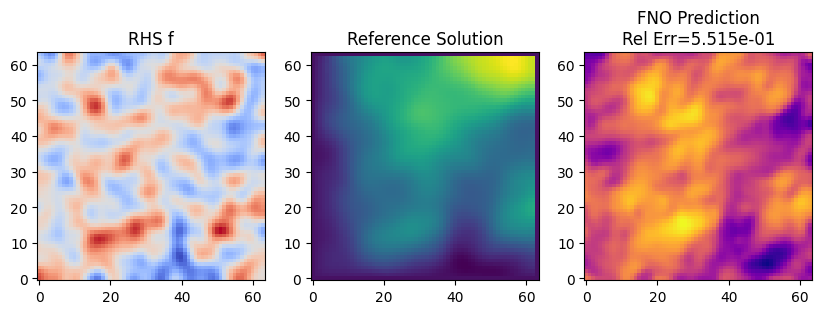

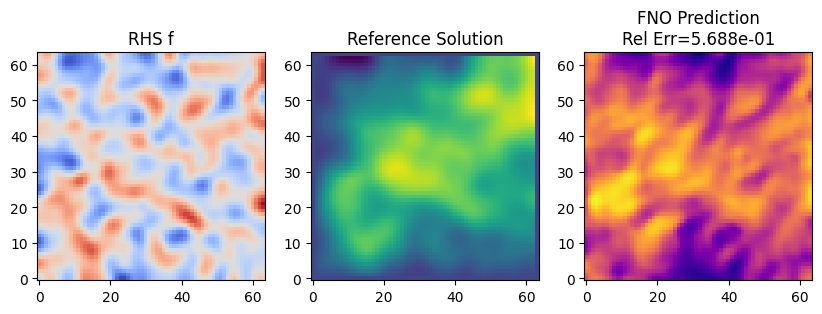

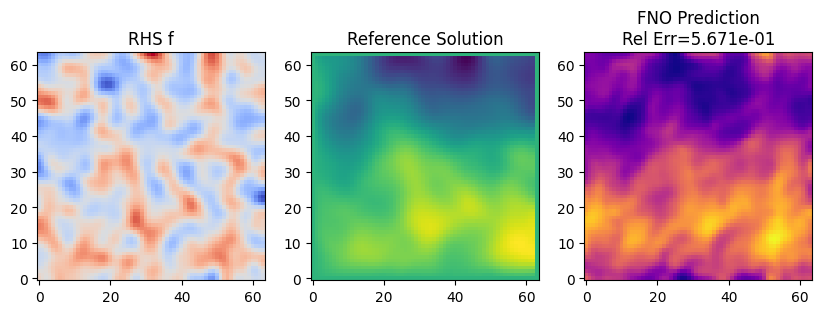

In [11]:
#@title Cell E — Evaluate FNO predictions
import matplotlib.pyplot as plt
import numpy as np
import torch

# Load model
model = FNO2d(MODES, MODES, WIDTH).to(DEVICE)
model.load_state_dict(torch.load('fno_poisson.pth', map_location=DEVICE))
model.eval()

# Pick random samples from validation
num_samples = 3
for i in range(num_samples):
    idx = np.random.randint(trainN, N)
    f = F_all[idx:idx+1]
    u_ref = U_all[idx:idx+1]

    f_tensor = torch.tensor(f, dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        u_pred = model(f_tensor).cpu().numpy()

    # Undo normalization
    u_pred = u_pred * (U_std + 1e-9) + U_mean
    u_ref = u_ref * (U_std + 1e-9) + U_mean
    f_plot = f * (F_std + 1e-9) + F_mean

    # Compute relative error
    rel_err = np.linalg.norm(u_pred - u_ref) / (np.linalg.norm(u_ref) + 1e-9)

    plt.figure(figsize=(10, 3))
    plt.subplot(1,3,1)
    plt.imshow(f_plot[0], origin='lower', cmap='coolwarm')
    plt.title("RHS f")
    plt.subplot(1,3,2)
    plt.imshow(u_ref[0], origin='lower', cmap='viridis')
    plt.title("Reference Solution")
    plt.subplot(1,3,3)
    plt.imshow(u_pred[0], origin='lower', cmap='plasma')
    plt.title(f"FNO Prediction\nRel Err={rel_err:.3e}")
    plt.show()
